# Neural Machine Translation

In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## 1. Data

## Translation files

In [2]:
from fastai.text import *

**Download dataset**

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html . It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [6]:
%cd data
%mkdir translate

/home/ubuntu/data


~20 minutes to download at 1.5 MB/s

In [8]:
!aria2c --file-allocation=none -c -x 5 -s 5 http://www.statmt.org/wmt10/training-giga-fren.tar

[#48abf9 32KiB/2.4GiB(0%) CN:5 DL:73KiB ETA:9h34m4s]     
07/02 05:11:30 [ERROR] CUID#10 - Download aborted. URI=http://www.statmt.org/wmt10/training-giga-fren.tar
Exception: [AbstractCommand.cc:350] errorCode=29 URI=http://www.statmt.org/wmt10/training-giga-fren.tar
  -> [HttpSkipResponseCommand.cc:224] errorCode=29 The response status is not successful. status=503

07/02 05:11:30 [ERROR] CUID#8 - Download aborted. URI=http://www.statmt.org/wmt10/training-giga-fren.tar
Exception: [AbstractCommand.cc:350] errorCode=29 URI=http://www.statmt.org/wmt10/training-giga-fren.tar
  -> [HttpSkipResponseCommand.cc:224] errorCode=29 The response status is not successful. status=503

07/02 05:11:30 [ERROR] CUID#7 - Download aborted. URI=http://www.statmt.org/wmt10/training-giga-fren.tar
Exception: [AbstractCommand.cc:350] errorCode=29 URI=http://www.statmt.org/wmt10/training-giga-fren.tar
  -> [HttpSkipResponseCommand.cc:224] errorCode=29 The response status is not successful. status=503
 *** Down

 *** Download Progress Summary as of Mon Jul  2 05:33:42 2018 ***              
[#48abf9 2.2GiB/2.4GiB(92%) CN:2 DL:1.6MiB ETA:2m3s]
FILE: /home/ubuntu/data/training-giga-fren.tar
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  2 05:34:43 2018 ***              
[#48abf9 2.3GiB/2.4GiB(95%) CN:2 DL:1.5MiB ETA:1m5s]
FILE: /home/ubuntu/data/training-giga-fren.tar
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  2 05:35:44 2018 ***              
[#48abf9 2.4GiB/2.4GiB(99%) CN:2 DL:1.7MiB ETA:1s]
FILE: /home/ubuntu/data/training-giga-fren.tar
-------------------------------------------------------------------------------

[#48abf9 2.4GiB/2.4GiB(99%) CN:2 DL:1.7MiB]                       
07/02 05:35:45 [NOTICE] Download complete: /home/ubuntu/data/training-giga-fren.tar

Download Results:
gid   |stat|avg speed  |path/URI
======+====+====

In [11]:
!tar -xf training-giga-fren.tar

In [13]:
%mv giga-fren.release2.fixed.en.gz giga-fren.release2.fixed.fr.gz training-giga-fren.tar translate/

In [14]:
%cd translate/

/home/ubuntu/data/translate


In [18]:
# Strange error
!tar -xzf giga-fren.release2.fixed.en.gz

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors


In [19]:
# Resolve the previous issue
!gunzip giga-fren.release2.fixed.en.gz

In [20]:
!gunzip giga-fren.release2.fixed.fr.gz

In [22]:
%cd ../..

/home/ubuntu


**Setup the directories and files**

In [27]:
PATH = Path('data/translate')
TMP_PATH = PATH / 'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname = 'giga-fren.release2.fixed'
en_fname = PATH / f'{fname}.en'
fr_fname = PATH / f'{fname}.fr'

### Tokenizing and Pre-processing

Training a neural model takes a long time

- Google's model has 8 layers
- we are going to build a simpler one
- Instead of a general model we will translate French questions

In [30]:
# Question regex search filters
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

# grabbing lines from the English and French source texts
lines = ( (re_eq.search(eq), re_fq.search(fq))
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

# isolate the questions
qs = [(e.group(), f.group()) for e, f in lines if e and f]

In [40]:
# save the questions for later
pickle.dump(qs, (PATH / 'fr-en-qs.pkl').open('wb'))

In [41]:
# load in pickled questions
qs = pickle.load((PATH / 'fr-en-qs.pkl').open('rb'))

In [46]:
# ======================================== START DEBUG ========================================
print(len(qs))
print(qs[:5])
# ======================================== END DEBUG ========================================

52331
[('What is light ?', 'Qu’est-ce que la lumière?'), ('Who are we?', 'Où sommes-nous?'), ('Where did we come from?', "D'où venons-nous?"), ('What would we do without it?', 'Que ferions-nous sans elle ?'), ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?', 'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')]


In [58]:
# ======================================== START DEBUG ========================================
# Python zip method: https://www.programiz.com/python-programming/methods/built-in/zip
# What is iterable, iterator: https://stackoverflow.com/questions/9884132/what-exactly-are-iterator-iterable-and-iteration
coord = ['x', 'y', 'z']
value = [3, 4, 5, 0, 9]
result = zip(coord, value)
result_list = list(result)
print(result_list)
# unzip result_list
c, v = zip(*result_list)
print(c)
print(v)
# ======================================== END DEBUG ========================================

[('x', 3), ('y', 4), ('z', 5)]
('x', 'y', 'z')
(3, 4, 5)


Tokenize all the questions.

In [59]:
en_qs, fr_qs = zip(*qs)

In [63]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

_Note: tokenizing for French is much different compared to english_

In [68]:
# Download spaCy 'fr' model.Otherwise, you'll encounter errorr "OSError: [E050] Can't find model 'fr'..."
!python -m spacy download fr

    100% |████████████████████████████████| 39.8MB 71.0MB/s ta 0:00:01
  Running setup.py install for fr-core-news-sm ... done
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/fr_core_news_sm
    -->
    /home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/spacy/data/fr

    You can now load the model via spacy.load('fr')



In [69]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [73]:
en_tok[:3], fr_tok[:3]

([['what', 'is', 'light', '?'],
  ['who', 'are', 'we', '?'],
  ['where', 'did', 'we', 'come', 'from', '?']],
 [['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'],
  ['où', 'sommes', '-', 'nous', '?'],
  ["d'", 'où', 'venons', '-', 'nous', '?']])

Check stats for the sentences length

In [74]:
# 90th percentile of English and French sentences length.
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

(23.0, 28.0)

We are keeping tokens that are less than 30 chars. The filter is applied on the English words, and the same tokens are kept for French.

In [75]:
keep = np.array([len(o) < 30 for o in en_tok])

In [85]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [90]:
# save our work
pickle.dump(en_tok, (PATH / 'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH / 'fr_tok.pkl').open('wb'))

In [101]:
def toks2ids(tok, pre):
    """
    Numericalize words to integers.
    
    Arguments:
        tok: token
        pre: prefix
    """
    freq = Counter(p for o in tok for p in o)
    itos = [o for o, c in freq.most_common(40000)] # 40k most common words
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, { v: k for k, v in enumerate(itos) }) #reverse
    ids = np.array([ ([stoi[o] for o in p] + [2]) for p in tok ])
    np.save(TMP_PATH / f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH / f'{pre}_itos.pkl', 'wb'))
    return ids, itos, stoi

In [102]:
en_ids, en_itos, en_stoi = toks2ids(en_tok, 'en')
fr_ids, fr_itos, fr_stoi = toks2ids(fr_tok, 'fr')

In [110]:
def load_ids(pre):
    ids = np.load(TMP_PATH / f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH / f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, { v: k for k, v in enumerate(itos) })
    return ids, itos, stoi

In [111]:
en_ids, en_itos, en_stoi = load_ids('en')
fr_ids, fr_itos, fr_stoi = load_ids('fr')

In [116]:
# Sanity check
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?', '_eos_'], 17573, 24793)

## Word vectors

Facebook's fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html

Download word vectors:

We are using the pre-trained word vectors for English language, trained on Wikipedia using fastText. These vectors in dimension 300 were obtained using the skip-gram model: https://fasttext.cc/docs/en/pretrained-vectors.html

In [118]:
!aria2c --file-allocation=none -c -x 5 -s 5 -d data/translate https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip

 *** Download Progress Summary as of Mon Jul  2 14:55:13 2018 ***              
[#fe81f7 2.9GiB/9.6GiB(30%) CN:5 DL:55MiB ETA:2m5s]
FILE: data/translate/wiki.en.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  2 14:56:14 2018 ***              
[#fe81f7 5.8GiB/9.6GiB(60%) CN:5 DL:52MiB ETA:1m14s]
FILE: data/translate/wiki.en.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  2 14:57:14 2018 ***              
[#fe81f7 8.6GiB/9.6GiB(89%) CN:5 DL:52MiB ETA:19s]
FILE: data/translate/wiki.en.zip
-------------------------------------------------------------------------------

[#fe81f7 9.6GiB/9.6GiB(99%) CN:2 DL:39MiB]                        
07/02 14:57:39 [NOTICE] Download complete: data/translate/wiki.en.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=================================================

In [119]:
!aria2c --file-allocation=none -c -x 5 -s 5 -d data/translate https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip

 *** Download Progress Summary as of Mon Jul  2 15:01:29 2018 ***              
[#2e6d55 2.5GiB/5.5GiB(45%) CN:5 DL:34MiB ETA:1m29s]
FILE: data/translate/wiki.fr.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon Jul  2 15:02:29 2018 ***              
[#2e6d55 5.3GiB/5.5GiB(95%) CN:5 DL:42MiB ETA:5s]
FILE: data/translate/wiki.fr.zip
-------------------------------------------------------------------------------

[#2e6d55 5.5GiB/5.5GiB(99%) CN:1 DL:11MiB]                        
07/02 15:02:47 [NOTICE] Download complete: data/translate/wiki.fr.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
2e6d55|OK  |    41MiB/s|data/translate/wiki.fr.zip

Status Legend:
(OK):download completed.


In [123]:
!unzip data/translate/wiki.en.zip -d data/translate/

Archive:  data/translate/wiki.en.zip
  inflating: data/translate/wiki.en.vec  
  inflating: data/translate/wiki.en.bin  


In [124]:
!unzip data/translate/wiki.fr.zip -d data/translate/

Archive:  data/translate/wiki.fr.zip
  inflating: data/translate/wiki.fr.vec  
  inflating: data/translate/wiki.fr.bin  


To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [125]:
!pip install git+https://github.com/facebookresearch/fastText.git

  Cloning https://github.com/facebookresearch/fastText.git to /tmp/pip-9tychtgg-build
    100% |████████████████████████████████| 153kB 1.8MB/s ta 0:00:01
  Running setup.py install for fasttext ... done
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [126]:
import fastText as ft

In [127]:
en_vecs = ft.load_model(str((PATH / 'wiki.en.bin')))

In [128]:
fr_vecs = ft.load_model(str((PATH / 'wiki.fr.bin')))

In [130]:
def get_vecs(lang, ft_vecs):
    """
    Convert fastText word vectors into a standard Python dictionary to make it a bit easier to work with.
    This is just going through each word with a dictionary comprehension and save it as a pickle dictionary.
    
    get_word_vector:
        [method] get the vector representation of word.
    get_words:
        [method] get the entire list of words of the dictionary optionally
        including the frequency of the individual words. This
        does not include any subwords. 
    """
    vecd = { w: ft_vecs.get_word_vector(w) for w in ft_vecs.get_words() }
    pickle.dump(vecd, open(PATH / f'wiki.{lang}.pkl', 'wb'))
    return vecd

In [131]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [132]:
en_vecd = pickle.load(open(PATH / 'wiki.en.pkl', 'rb'))
fr_vecd = pickle.load(open(PATH / 'wiki.fr.pkl', 'rb'))

In [133]:
# DEBUG
ft_vecs = en_vecs

In [136]:
# DEBUG
ft_words = ft_vecs.get_words(include_freq=True)
ft_word_dict = { k: v for k, v in zip(*ft_words) }
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])
len(ft_words)

2519370

In [149]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec, dim_fr_vec

(300, 300)

Find out what the mean and standard deviation of our vectors are. So the mean is about zero and standard deviation is about 0.3.

In [179]:
# en_vecd type is dict
en_vecs = np.stack(list(en_vecd.values())) # convert dict_values to list and then stack it
en_vecs.mean(), en_vecs.std()

(0.0075652334, 0.29283327)

## Model data

**Exclude the extreme cases**

Often corpuses have a pretty long tailed distribution of sequence length and it's the longest sequences that tend to overwhelm how long things take, how much memory is used, etc. So in this case, we are going to grab 99th to 97th percentile of the English and French and truncate them to that amount. Originally Jeremy was using 90 percentiles (hence the variable name):

In [157]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 99))
enlen_90, frlen_90

(29, 38)

In [158]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

**Create our Dataset, DataLoaders**

In [159]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __getitem__(self, idx):
        return A(self.x[idx], self.y[idx]) # A for Arrays
    
    def __len__(self):
        return len(self.x)

**Split the training and testing set**

Here is an easy way to get training and validation sets. Grab a bunch of random numbers — one for each row of your data, and see if they are bigger than 0.1 or not. That gets you a list of booleans. Index into your array with that list of booleans to grab a training set, index into that array with the opposite of that list of booleans to get your validation set.

In [160]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr)) > 0.1
en_trn, fr_trn = en_ids_tr[trn_keep], fr_ids_tr[trn_keep] # training set
en_val, fr_val = en_ids_tr[~trn_keep], fr_ids_tr[~trn_keep] # validation set
len(en_trn), len(en_val)

(45219, 5041)

**Create training and validation sets**

In [162]:
trn_ds = Seq2SeqDataset(fr_trn, en_trn)
val_ds = Seq2SeqDataset(fr_val, en_val)

In [163]:
# Set batch size
bs = 125

- Most of our preprocessing is complete, so making `numworkers = 1` will save you some time.
- Padding will pad the shorter phrases to be the same length.
- Classifier → padding in the beginning.
- Decoder → padding at the end.
- Sampler - so we keep the similar sentences together (sorted by length).

In [165]:
# arranges sentences so that similar lengths are close to each other
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

**Create DataLoaders**

In [167]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1,
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs * 1.6), transpose=True, transpose_y=True, num_workers=1,
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [169]:
# Test - inspect

it = iter(trn_dl) # trn_dl is iterable. turns iterable into iterator.
# Return the next item from the iterator.
its = [next(it) for i in range(5)]
[(len(x), len(y)) for x, y in its]

[(38, 29), (21, 7), (21, 8), (38, 13), (38, 21)]

## 2. Architecture

## Initial model

![Architecture diagram](https://s15.postimg.cc/x710hbkdn/1_1f_KDa_Dsww_Vu3w2_Zt_Cg-_Uow.png)

- The architecture is going to take our sequence of tokens.
- It is going to spit them into an encoder (a.k.a. backbone).
- That is going to spit out the final hidden state which for each sentence, it’s just a single vector.
- Then, it will need to be passed to a decoder that will walk through the words one by one.

In [170]:
def create_emb(vecs, itos, em_sz):
    """
    Creates embedding:
    1. rows = number of vocab
    2. cols = embedding size dimension
    
    Will randomly initialize the embedding
    """
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    
    # goes through the embedding and replace
    # the initialized weights with existing word vectors
    # multiply x3 to compensate for the stdev 0.3
    for i, w in enumerate(itos):
        try:
            wgts[i] = torch.from_numpy(vecs[w] * 3)
        except:
            miss.append(w)
    print(len(miss), miss[5:10])
    return emb

In [171]:
nh, nl = 256, 2

In [172]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        
        # encoder (enc)
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        
        # for each word, pull up the 300M vector and create an embedding
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        
        # GRU - similiar to LSTM
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        # decoder (dec)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl, bs = inp.size()

        # ==================================================
        # Encoder version
        # ==================================================
        
        # initialize the hidden layer
        h = self.initHidden(bs)
        
        # run the input through our embeddings + apply dropout
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        # run it through the RNN layer
        enc_out, h = self.gru_enc(emb, h)
        
        # run the hidden state through our linear layer
        # note: we are only using the last hidden state to 'decode' into another phrase
        h = self.out_enc(h)
        
        # ==================================================
        # Decoder version
        # ==================================================
        
        # starting with a 0 (or beginning of string _BOS_)
        dec_inp = V(torch.zeros(bs).long())
        res = []
        
        # will loop as long as the longest english sentence
        for i in range(self.out_sl):
            
            # embedding - we are only looking at a section at time
            # which is why the .unsqueeze is required
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            
            # rnn - typically works with whole phrases, but we passing
            # only 1 unit at a time in a loop
            outp, h = self.gru_dec(emb, h)
            
            # dropout
            outp = self.out(self.out_drop(outp[0]))
            
            res.append(outp)
            
            # highest probability word
            dec_inp = V(outp.data.max(1)[1])
            
            # if its padding ,we are at the end of the sentence
            if (dec_inp == 1).all():
                break

        # stack the output into a single tensor
        return torch.stack(res)

    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))
        

In [173]:
def seq2seq_loss(input, target):
    """
    Loss function - modified version of cross entropy
    """
    sl, bs = target.size()
    sl_in, bs_in, nc = input.size()
    
    # sequence length could be shorter than the original
    # need to add padding to even out the size
    if sl > sl_in:
        input = F.pad(input, (0, 0, 0, 0, 0, sl - sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1, nc), target.view(-1))#, ignore_index=1)

In [174]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [175]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


 65%|██████▍   | 235/362 [01:11<00:38,  3.28it/s, loss=29.5]

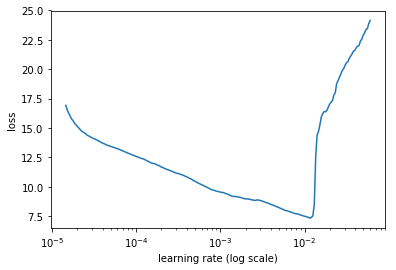

In [176]:
# Find the learning rate
learn.lr_find()
learn.sched.plot()

**Fit the model (15-20 mins to train)**

In [177]:
lr = 3e-3

In [178]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20, 10))

epoch      trn_loss   val_loss                              
    0      5.209042   5.980303  
    1      4.513244   4.566818                              
    2      4.056711   4.515142                              
    3      3.775803   4.026515                              
    4      3.595237   3.857968                              
    5      3.519258   3.773164                              
    6      3.160189   3.705156                              
    7      3.108818   3.66531                               
    8      3.142783   3.613333                              
    9      3.192778   3.680305                              
    10     2.844773   3.637095                              
    11     2.857365   3.5963                                


[array([3.5963])]

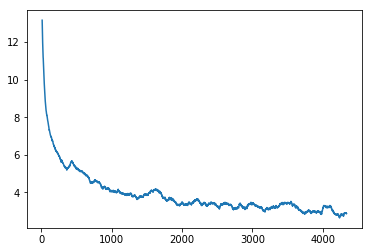

In [180]:
learn.sched.plot_loss()

In [181]:
learn.save('initial')

In [182]:
learn.load('initial')

### Test

In [188]:
x, y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180, 190):
    print(' '.join([ fr_itos[o] for o in x[:, i] if o != 1 ]))
    print(' '.join([ en_itos[o] for o in y[:, i] if o != 1 ]))
    print(' '.join([ en_itos[o] for o in preds[:, i] if o != 1 ]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what aspects of the and and be be be be be be be be be ? ? _eos_

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what minister the minister minister minister minister minister , , , , health health and health ? ? ? ? _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growing forms of non - standar

## Bi-direction

Take all your sequences and reverse them and make a "backwards model" then average the predictions. Note that with deeper models, not all levels may be bi-directional.

In [191]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True) # for bidir, bidirectional=True
        self.out_enc = nn.Linear(nh * 2, em_sz_dec, bias=False) # for bidir, nh * 2
        self.drop_enc = nn.Dropout(0.05) # additional for bidir
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

    def forward(self, inp):
        sl, bs = inp.size()

        # ==================================================
        # Encoder version
        # ==================================================

        # initialize the hidden layer
        h = self.initHidden(bs)

        # run the input through our embeddings + apply dropout
        emb = self.emb_enc_drop(self.emb_enc(inp))

        # run it through the RNN layer
        enc_out, h = self.gru_enc(emb, h)

        # Additional for bidir
        h = h.view(2, 2, bs, -1).permute(0, 2, 1, 3).contiguous().view(2, bs, -1)
        
        # run the hidden state through our linear layer
        h = self.out_enc(self.drop_enc(h)) # new for bidir; dropout hidden state.

        # ==================================================
        # Decoder version
        # ==================================================

        # starting with a 0 (or beginning of string _BOS_)
        dec_inp = V(torch.zeros(bs).long())
        res = []

        # will loop as long as the longest english sentence
        for i in range(self.out_sl):

            # embedding - we are only looking at a section at time
            # which is why the .unsqueeze is required
            emb = self.emb_dec(dec_inp).unsqueeze(0)

            # rnn - typically works with whole phrases, but we passing
            # only 1 unit at a time in a loop
            outp, h = self.gru_dec(emb, h)

            # dropout
            outp = self.out(self.out_drop(outp[0]))

            res.append(outp)

            # highest probability word
            dec_inp = V(outp.data.max(1)[1])

            # if its padding ,we are at the end of the sentence
            if (dec_inp == 1).all():
                break

        # stack the output into a single tensor
        return torch.stack(res)

    def initHidden(self, bs):
        return V(torch.zeros(self.nl * 2, bs, self.nh)) # for bidir, sel.nl * 2

In [192]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [193]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20, 10))

epoch      trn_loss   val_loss                              
    0      4.766771   4.495123  
    1      3.918195   4.018911                              
    2      3.682928   3.852527                              
    3      3.654867   3.653316                              
    4      3.540806   3.581977                              
    5      3.38937    3.518663                              
    6      3.337964   3.461221                              
    7      2.868424   3.439734                              
    8      2.783658   3.426322                              
    9      2.743709   3.375462                              
    10     2.662714   3.39351                               
    11     2.551906   3.373751                              


[array([3.37375])]

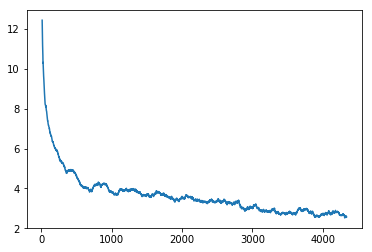

In [196]:
learn.sched.plot_loss()

In [194]:
learn.save('bidir')

In [195]:
learn.load('bidir')

**Test**

In [197]:
x, y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180, 190):
    print(' '.join([ fr_itos[o] for o in x[:, i] if o != 1 ]))
    print(' '.join([ en_itos[o] for o in y[:, i] if o != 1 ]))
    print(' '.join([ en_itos[o] for o in preds[:, i] if o != 1 ]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
which aspects of should should should be be and and how how how be be be ? ? _eos_ _eos_

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
who is the minister minister minister to minister mental mental mental mental mental health health ? ? ? _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growi

## Teacher forcing

When the model starts learning, it starts out not knowing anything about the different languages. It will eventually get better, but in the beginning it doesn't have a lot to work with.

**idea:** what if we force feed the correct answer in the beginnging?

In [198]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10 - epoch) * 0.1 if epoch < 10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output, tuple):
            output, *xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn:
            loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip: # gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        
        return raw_loss.data[0]

In [199]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1. # new for teacher forcing

    def forward(self, inp, y=None): # argument y is new for teacher forcing
        sl, bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        
        dec_inp = V(torch.zeros(bs).long())
        res = []
        
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            
            if (dec_inp == 1).all():
                break
            if (y is not None) and (random.random() < self.pr_force): # new for teacher forcing
                if i >= len(y):
                    break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))

In [200]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [201]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20, 10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.972275   11.894288 
    1      3.75144    8.904335                              
    2      3.147096   5.737202                              
    3      3.205919   4.434411                              
    4      2.89941    4.337346                              
    5      2.837049   4.195613                              
    6      2.9374     3.801485                              
    7      2.919509   3.679037                              
    8      2.974855   3.600216                              
    9      2.98231    3.551779                              
    10     2.871864   3.418646                              
    11     2.674465   3.432893                              


[array([3.43289])]

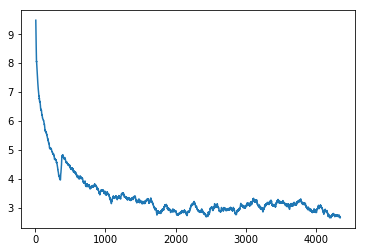

In [202]:
learn.sched.plot_loss()

In [203]:
learn.save('forcing')
learn.load('forcing')

**Test**

In [204]:
x, y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180, 190):
    print(' '.join([ fr_itos[o] for o in x[:, i] if o != 1 ]))
    print(' '.join([ en_itos[o] for o in y[:, i] if o != 1 ]))
    print(' '.join([ en_itos[o] for o in preds[:, i] if o != 1 ]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what elements of the should be be be be and and and and ? ? ? ?

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what is the minister of the the of the and and and and and and mental health ? ? ? _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growing forms of non - standard employment for highl

## Attentional model

Our RNN model exports the hidden state at every time step, along with the hidden state at the last time step. Initially we are only using the LAST hidden state to 'decode' into another phrase.

Can we use the rest of those hidden states?

**goal:** use some percentage of all hidden states and add another trainable parameter to find good answers in the model.

**idea:** expecting the entire sentence to be summarized into a vector is a lot. Instead of having a hidden state at the end of the phrase, we can have a hidden state after every single word. So how do we use the hidden information after every word.

In [205]:
def rand_t(*sz):
    return torch.randn(sz) / math.sqrt(sz[0])

def rand_p(*sz):
    return nn.Parameter(rand_t(*sz))

In [220]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        # these 4 lines are addition for 'attention'        
        self.W1 = rand_p(nh, em_sz_dec) # random matrix wrapped up in PyTorch Parameter
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec) # this is the mini NN that will calculate the weights
        self.l3 = nn.Linear(em_sz_dec + nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl, bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res, attns = [], [] # attns is addition for 'attention'
        w1e = enc_out @ self.W1 # this line is addition for 'attention'. matrix product.

        for i in range(self.out_sl):
            # these 5 lines are addition for 'attention'.
            
            # create a little neural network.
            # use softmax to generate the probabilities.
            w2h = self.l2(h[-1]) # take last layers hidden state put into linear layer
            u = F.tanh(w1e + w2h) # nonlinear activation
            a = F.softmax(u @ self.V, 0) # matrix product
            attns.append(a)
            # take a weighted average. Use the weights from mini NN.
            # note we are using all the encoder states
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            
            emb = self.emb_dec(dec_inp)
            # adding the hidden states to the encoder weights
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) # this line is addition for 'attention'
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h) # this line has changed for 'attention'
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all():
                break
            if (y is not None) and (random.random() < self.pr_force): # why is teacher forcing logic still here? bug?
                if i >= len(y):
                    break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn:
            res = res, torch.stack(attns) # bug?
        return res

    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))

In [224]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [208]:
lr = 2e-3

In [209]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20, 10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.780541   14.757052 
    1      3.221531   5.661915                              
    2      2.901307   4.924356                              
    3      2.875144   4.647381                              
    4      2.704298   3.912943                              
    5      2.69899    4.401953                              
    6      2.78165    3.864044                              
    7      2.765688   3.614325                              
    8      2.873574   3.417437                              
    9      2.826172   3.370511                              
    10     2.845763   3.293398                              
    11     2.66649    3.300835                              
    12     2.697862   3.258844                              
    13     2.659374   3.267969                              
    14     2.585613   3.240595                              


[array([3.24059])]

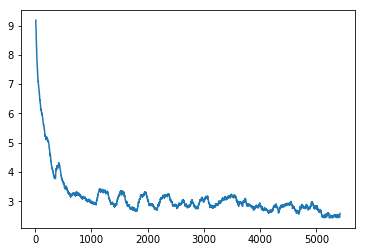

In [210]:
learn.sched.plot_loss()

In [211]:
learn.save('attn')

In [226]:
learn.load('attn')

**Test**

In [228]:
x, y = next(iter(val_dl))
probs, attns = learn.model(V(x), ret_attn=True)
preds = to_np(probs.max(2)[1])

In [236]:
for i in range(180, 190):
    print(' '.join([fr_itos[o] for o in x[:, i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:, i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:, i] if o != 1]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what components of the performance should be be be data be and and how ? ? _eos_ ?

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what is the minister minister ’s minister minister to to minister to health health ? and mental mental health _eos_ _eos_ mental _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is t

#### Visualization

In [237]:
attn = to_np(attns[..., 180])

In [248]:
# DEBUG
print(attn.shape)

# graph 1
print(attn[0].shape)
print(attn[0][:10])
# END DEBUG

(29, 38)
(38,)
[0.00093 0.38696 0.50663 0.05482 0.00831 0.0026  0.00418 0.00047 0.00101 0.00141]


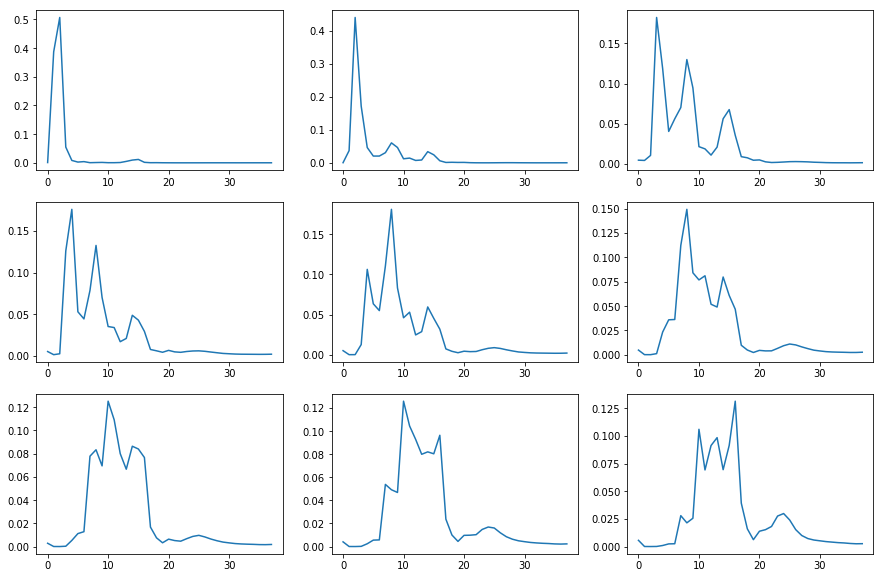

In [241]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.plot(attn[i])